In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from jsbsim_utils import Logger, trim, simulate

Nonlinear-dynamics of aircraft

$$\dot{x} = f(x, u)$$

Find equilibrium:

Minimize $\dot{x}$, or a subset for your problem, by changeing $x_0$, $u_0$

$$0 = f(x_0, u_0)$$

This is an optimization problem.

* Matlab: fmincon, fminsearch
* Python: scipy.minimize (Nelder-Mead, SLSQP)

Can simplify this problem with mixing matrices, to decouple the dynamcis into SISO (single-input-single output) systems.

Due to Taylor series error on the order of (dx^2). We know the linear model approx, does well near the equilibrium point. 

$\dot{\vec{x}} = \vec{f}(x, u) = A \vec{x} + B \vec{u}$

$\dot{\vec{y}} = C \vec{x} + D \vec{u}$


$A = \dfrac{\delta \vec{f}(x0, u0)}{\delta \vec{x}}$

$B = \dfrac{\delta \vec{f}(x0, u0)}{\delta \vec{u}}$

$C = \dfrac{\delta \vec{y}(x0, u0)}{\delta \vec{x}}$

$D = \dfrac{\delta \vec{y}(x0, u0)}{\delta \vec{u}}$

In [31]:
ct = 0
temp = []
def cost_ground(fdm):
    # modify cost to also penalize throttle   
    udot = fdm['accelerations/udot-ft_sec2']
    vdot = fdm['accelerations/vdot-ft_sec2']
    wdot = fdm['accelerations/wdot-ft_sec2']
    pdot = fdm['accelerations/pdot-rad_sec2']
    qdot = fdm['accelerations/qdot-rad_sec2']
    rdot = fdm['accelerations/rdot-rad_sec2']
    temp.append(fdm.get_property_catalog('fbz'))
    return udot**2 + vdot**2 + wdot**2 + pdot**2 + qdot**2 + rdot**2  
        
op_ground, fdm = trim(
    aircraft='F-35B-2',
    ic={
        'ic/vt-fps': 0,
        'gear/gear-cmd-norm': 1,
        'propulsion/engine/pitch-angle-rad': np.deg2rad(0),
        'fcs/throttle-cmd-norm': 0,
        'fcs/aileron-cmd-norm': 0,
        'fcs/elevator-cmd-norm': 0,
        'fcs/rudder-cmd-norm': 0,
        'fcs/left-brake-cmd-norm': 1,
        'fcs/right-brake-cmd-norm': 1,
        'fcs/center-brake-cmd-norm': 1,
    },
    design_vector=['ic/theta-rad', 'ic/h-agl-ft'],
    x0=[0, 3.681],
    verbose=True,
    method='Nelder-Mead', # works better with ground interaction
    tol=1e-12,
    #bounds=[[np.deg2rad(-40), np.deg2rad(40)], [0, 20]],
    cost=cost_ground,
)


op_ground
print(temp[0])
print(temp[-1])

 final_simplex: (array([[0.00749581, 3.11215078],
       [0.00749581, 3.11215078],
       [0.00749581, 3.11215078]]), array([9.04270073e-12, 9.04270131e-12, 9.10298982e-12]))
           fun: 9.042700734912258e-12
       message: 'Optimization terminated successfully.'
          nfev: 192
           nit: 86
        status: 0
       success: True
             x: array([0.00749581, 3.11215078])
{'forces/fbz-aero-lbs': -0.0, 'forces/fbz-weight-lbs': 11358.887102509612, 'forces/fbz-total-lbs': -2012.7077864684486, 'forces/fbz-gear-lbs': -2012.7077864684486, 'forces/fbz-prop-lbs': 0.0}
{'forces/fbz-aero-lbs': -0.0, 'forces/fbz-weight-lbs': 11358.593849167075, 'forces/fbz-total-lbs': -11335.795561853962, 'forces/fbz-gear-lbs': -11335.795561853962, 'forces/fbz-prop-lbs': 0.0}


In [9]:
log_ground = simulate(
    aircraft='F-35B-2',
    op_0=op_ground,
    tf=5,
    realtime=True)

<AxesSubplot:xlabel='t, sec'>

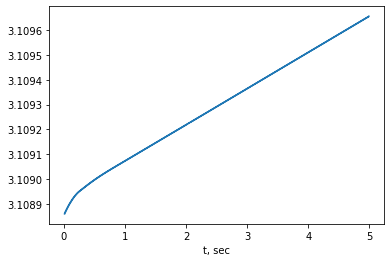

In [10]:
log_ground['position/h-agl-ft'].plot()

<AxesSubplot:xlabel='t, sec'>

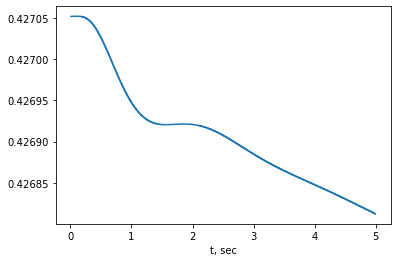

In [11]:
log_ground['attitude/theta-deg'].plot()

In [18]:
fdm.resume_integration()
fdm.get_propulsion().get_steady_state()

False

<AxesSubplot:xlabel='t, sec'>

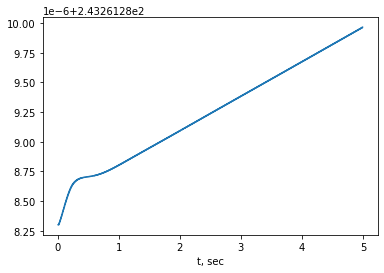

In [12]:
log_ground['propulsion/engine/thrust-lbs'].plot()

In [34]:
op_hover, fdm = trim(
    aircraft='F-35B-2',
    ic={
        'ic/h-agl-ft': 10,
        'ic/vd-fps': 0,
        'ic/vn-fps': 0*np.cos(np.deg2rad(280)),
        'ic/ve-fps': 0*np.sin(np.deg2rad(280)),
        'ic/theta-rad': 0,
        'gear/gear-cmd-norm': 1,
        'fcs/left-brake-cmd-norm': 0,
        'fcs/right-brake-cmd-norm': 0,
        'fcs/center-brake-cmd-norm': 0,
    },
    design_vector=[
        'fcs/throttle-cmd-norm',
        'fcs/elevator-cmd-norm',
        'propulsion/engine/pitch-angle-rad',
        'propulsion/engine[1]/pitch-angle-rad',
        'propulsion/engine[2]/pitch-angle-rad',
        'propulsion/engine[3]/pitch-angle-rad',
    ],
    x0=[0.5, 0, np.deg2rad(90), np.deg2rad(90), np.deg2rad(90), np.deg2rad(90)],
    verbose=True,
    bounds=[[0, 1], [-1, 1], [np.deg2rad(0), np.deg2rad(120)], 
           [np.deg2rad(0), np.deg2rad(120)],
           [np.deg2rad(0), np.deg2rad(120)],
           [np.deg2rad(0), np.deg2rad(120)]],
    tol=1e-12
)
op_hover
print(fdm.get_property_catalog('dot'))

      fun: 8.855948537345098e-12
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.45794034e-06, -3.74771872e-07, -2.78537761e-07, -3.95065336e-07,
       -2.51641947e-07, -3.76151362e-07])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 259
      nit: 16
     njev: 37
   status: 0
  success: True
        x: array([0.92874054, 0.71683748, 1.57179653, 1.5693725 , 1.57179654,
       1.5693725 ])
{'velocities/h-dot-fps': -0.0, 'velocities/phidot-rad_sec': 0.0, 'velocities/thetadot-rad_sec': 0.0, 'velocities/psidot-rad_sec': 0.0, 'accelerations/pdot-rad_sec2': 1.8657114455788187e-09, 'accelerations/qdot-rad_sec2': 1.0488849405364631e-07, 'accelerations/rdot-rad_sec2': -1.4073216019254512e-08, 'accelerations/udot-ft_sec2': -6.790932451788967e-09, 'accelerations/vdot-ft_sec2': 2.95195145366689e-06, 'accelerations/wdot-ft_sec2': 3.562588801742095e-07, 'aero/alphadot-rad_sec': 0.0, 'aero/betadot-rad_sec': 0.0, 'aero/alphadot-deg_sec': 0.0, 'a

In [35]:
log_hover = simulate(
    aircraft='F-35B-2',
    op_0=op_hover,
    tf=5,
    realtime=True)

In [36]:
def cost_cruise(fdm):
    # modify cost to also penalize throttle
    delta = fdm['propulsion/engine/pitch-angle-rad']
    theta = fdm['attitude/theta-rad']
    drag = fdm['forces/fwx-aero-lbs']
    lift = fdm['forces/fwz-aero-lbs']
    alpha = fdm['aero/alpha-rad']
    throttle = fdm['fcs/throttle-cmd-norm']
    
    udot = fdm['accelerations/udot-ft_sec2']
    vdot = fdm['accelerations/vdot-ft_sec2']
    wdot = fdm['accelerations/wdot-ft_sec2']
    pdot = fdm['accelerations/pdot-rad_sec2']
    qdot = fdm['accelerations/qdot-rad_sec2']
    rdot = fdm['accelerations/rdot-rad_sec2']
    return udot**2 + vdot**2 + wdot**2 + pdot**2 + qdot**2 + rdot**2 - 1e-3*(lift/drag)**2 + 1e-3*(theta < 0) + 1e-1*throttle + 2e-1*delta**2 
        
op_cruise, fdm = trim(
    aircraft='F-35B-2',
    ic={
        'ic/gamma-rad': 0,
        'ic/vt-fps': 677,
        'ic/h-agl-ft': 38*1e3,
        'gear/gear-cmd-norm': 0,
        'fcs/left-brake-cmd-norm': 0,
        'fcs/right-brake-cmd-norm': 0,
        'fcs/center-brake-cmd-norm': 0,
        'propulsion/engine/pitch-angle-rad': 0,
    },
    design_vector=[
        'fcs/throttle-cmd-norm',
        'fcs/elevator-cmd-norm',
        'fcs/rudder-cmd-norm',
        'fcs/aileron-cmd-norm',
        'ic/alpha-rad',
        'ic/beta-rad',
        'propulsion/engine/pitch-angle-rad',
    ],
    cost=cost_cruise,
    x0=[0.4, 0, 0, 0, 0, 0, 0],
    verbose=True,
    bounds=[[0, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [np.deg2rad(0), np.deg2rad(120)]],
    tol=1e-12,
)
op_cruise

      fun: -0.07279137319063003
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.00000068e-01,  9.11520859e-05, -3.62682107e-05,  6.78235246e-05,
        3.34029193e-03,  2.59819943e-05,  5.21585969e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 760
      nit: 69
     njev: 95
   status: 0
  success: True
        x: array([ 0.        , -0.12367121,  0.00069518, -0.00020624,  0.02021778,
        0.00129227,  0.        ])


{'ic/gamma-rad': 0,
 'ic/vt-fps': 677,
 'ic/h-agl-ft': 38000.0,
 'gear/gear-cmd-norm': 0,
 'fcs/left-brake-cmd-norm': 0,
 'fcs/right-brake-cmd-norm': 0,
 'fcs/center-brake-cmd-norm': 0,
 'propulsion/engine/pitch-angle-rad': 0.0,
 'fcs/throttle-cmd-norm': 0.0,
 'fcs/elevator-cmd-norm': -0.12367121178077818,
 'fcs/rudder-cmd-norm': 0.0006951847767905014,
 'fcs/aileron-cmd-norm': -0.00020624021382990634,
 'ic/alpha-rad': 0.02021777920968398,
 'ic/beta-rad': 0.0012922701882664349}

In [37]:
log_cruise = simulate(
    aircraft='F-35B-2',
    op_0=op_cruise,
    tf=10,
    realtime=True)

In [17]:
fdm['propulsion']

0.0

In [19]:
log_cruise['forces/fwx-aero-lbs'].plot()

FGFDMExec 
root dir	:	C:/Users/Tomo/TomoCode/aae451/aae451-notebook/6-Simulation
aircraft path	:	C:/Users/Tomo/TomoCode/aae451/aae451-notebook/6-Simulation/aircraft
engine path	:	C:/Users/Tomo/TomoCode/aae451/aae451-notebook/6-Simulation/engine
systems path	:	C:/Users/Tomo/TomoCode/aae451/aae451-notebook/6-Simulation/systems

